----
Normalised Distance: 50.49
----


Text(0.5, 0, 'Keypoint Value')

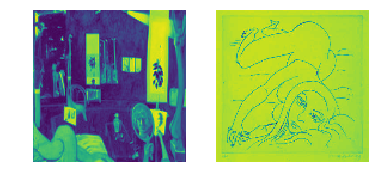

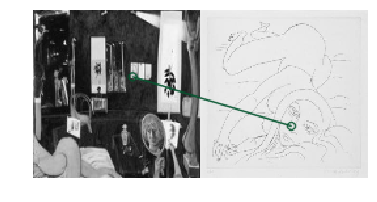

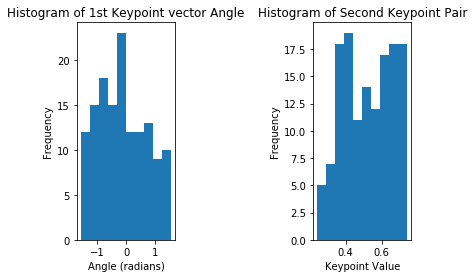

In [9]:
'''
Steve Winnall 10 Aug 2019
This code is work toward the Udacity Machine Learning NanoDegree Capstone Project
"The Art Thief - Is this a Whiteley?"
Using machine learning to identify a "fake" Brett Whiteley paiting.

This code is to perform feature extraction using ORB 
Ethan Rublee et. al. "ORB: An Efficient Alternative to SIFT or SURF"
https://ieeexplore.ieee.org/abstract/document/6126544/
ORB is used for a few reasons over SURF
- open source
- efficient
- rotationally invariant (extra saliency potential given the paintings are fixed orientation)

The code cycles through images in a directory and performs brute force matching of the keypoint pairs
The first keypoint pair is converted to a vector and the angle calculated
For extra discrimination the overall length of the keypoint pair lengths are summed 
(just the first keypoint pair length did not have significant discrimination)
The distribution of vectors is then calculated and converted to two histograms (length and angle)
If there is a narrow grouping of angle/length then it is proposed that the features could be used to discriminate/classify
'''

#imports
import cv2
import os
import math
import numpy as np 
import glob
from matplotlib import pyplot as plt
%matplotlib inline

#image sizing and selection
number_images = 140
img_size_val = 128

#create the ORB feature extractor object
img_size = (img_size_val,img_size_val)
orb = cv2.ORB_create()

#location of the directory wherre the images are located
file_list = glob.glob("data/train/brett/*.jpg") 
#print(file_list[:10])

#initialise variables
euclid_distance_val = 0
list_kp1 = []
list_kp2 = []
list_angle = []

#loop through the number of images and create the vectors
for loop_index in range (1, number_images):
    
    #convert to grayscale images and read them in
    image_1 = cv2.imread(file_list[0], cv2.IMREAD_GRAYSCALE)
    image_1 = cv2.resize(image_1, img_size)
    image_2 = cv2.imread(file_list[loop_index], cv2.IMREAD_GRAYSCALE)
    image_2 = cv2.resize(image_2, img_size)
    
    #create the keypoint pairs using the orb methoddetectAndCompute
    kp1, des1 = orb.detectAndCompute(image_1,None)
    kp2, des2 = orb.detectAndCompute(image_2,None)
    
    #perform brute force matching
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)
    matches = matches[:1]

    #of the keypoint pairs, select the keypoint pairs and generate the keypoint vector
    for mat in matches:

        # keypoint indices
        image1_idx = mat.queryIdx
        image2_idx = mat.trainIdx
        
        #create the vector of the overall keypoint length - this had more discrimination than just the first
        distance_val = mat.distance
        euclid_distance_val = euclid_distance_val + distance_val
        
        # obtain coordinate pairs
        (x1,y1) = kp1[image1_idx].pt
        (x2,y2) = kp2[image2_idx].pt

        #normalize relative to the size of the image
        (x1,y1) = (x1/img_size_val,y1/img_size_val)
        (x2,y2) = (x2/img_size_val,y2/img_size_val)
        
        #create the angle and handle divide by zero
        angle_nomin = (y2-y1)
        angle_denomin = (x2-x1)
        
        def angle_ratio(nomin,denomin):
            try:
                return nomin/denomin
            except ZeroDivisionError:
                return 0
        
        calc_angle = angle_ratio(angle_nomin,angle_denomin)
        angle_val = math.atan(calc_angle)
        
        list_angle.append(angle_val)
    
        # Append to each list
        list_kp1.append((x1,y1))
        list_kp2.append((x2))
    
    matching_result = cv2.drawMatches(image_1, kp1, image_2, kp2, matches[:1], None, flags=2)

normalised_euc_dist = euclid_distance_val/number_images

print("----")
print("Normalised Distance: {:.2f}".format(normalised_euc_dist))
print("----")

plt.figure()
plt.subplot(121)
plt.axis('off')
plt.imshow(image_1)
plt.subplot(122)
plt.axis('off')
plt.imshow(image_2)
plt.figure()
plt.axis('off')
plt.imshow(matching_result)

plt.figure()
plt.subplot(131)
plt.hist(list_angle,10) #10 bins
plt.title('Histogram of 1st Keypoint vector Angle')
plt.ylabel('Frequency')
plt.xlabel('Angle (radians)')
plt.subplot(133)
plt.hist(list_kp2,10) #10 bins
plt.title('Histogram of Second Keypoint Pair')
plt.ylabel('Frequency')
plt.xlabel('Keypoint Value')
